In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
import sys

%matplotlib inline

import matplotlib
# matplotlib.rc('text', usetex=False)  # <-- try this if plots don't work
matplotlib.rc('text', usetex=True) # <-- use this if your matplotlib is set up to play nice with latex

# simulation results

### a simple example

We first create a parameters we can simulate from:

In [2]:
# pick the number of populations and the number of different values that can be returned by each tool
num_ells=20
num_xs=6
num_ys=6

plx_star = np.array([npr.dirichlet(np.ones(num_xs)) for x in range(num_ells)])
qxy_star = np.array([npr.dirichlet(np.ones(num_ys)) for x in range(num_xs)])
hly_star= plx_star @qxy_star

Let's take a look at what we've made

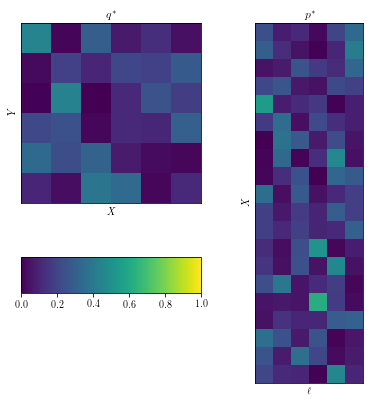

In [3]:
plt.gcf().set_size_inches(5,5)

plt.gcf().add_axes([0,.5,.5,.5])
plt.pcolor(qxy_star,vmin=0,vmax=1)
plt.title("$q^*$"); plt.xticks([]); plt.yticks([])
plt.xlabel("$X$")
plt.ylabel("$Y$")

plt.gcf().add_axes([.65,0,plx_star.shape[1]/plx_star.shape[0],1])
mappable=plt.pcolor(plx_star,vmin=0,vmax=1)
plt.title("$p^*$"); plt.xticks([]); plt.yticks([])
plt.xlabel("$\ell$")
plt.ylabel("$X$")

plt.gcf().add_axes([0,.25,.5,.1])
plt.colorbar(cax=plt.gca(),orientation='horizontal')


Now we simulate data:

In [4]:
nsamps=100
Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])

And run the MLM get our point estimate $\hat q$ and our credible intervals.

In [5]:
qhat,CIs = markovlink.estimates(Nlx,Nly)

Let's see how our estimates stack up to the truth

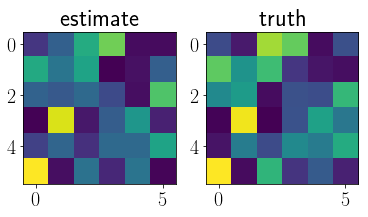

In [9]:
plt.subplot(1,2,1)
plt.imshow(qhat)
plt.title("estimate")
plt.subplot(1,2,2)
plt.imshow(qxy_star)
plt.title("truth");

We can see that $q^*$ and $\tilde q$ look fairly similar in basic character.  We can measure their difference quantitatively, through the total variation distance averaged over the rows.  This error measurement ranges from 0 to 1.

In [11]:
markovlink.totalvardist(qhat,qxy_star)

0.153401624652266

Let's see where the total variation is coming from:

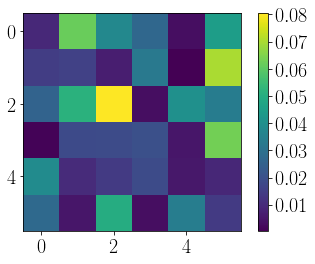

In [12]:
plt.imshow(np.abs(qhat-qxy_star)*.5)
plt.colorbar()

Anyway, not terrible error.

Now let's look at the credible intervals.  It is hard to visualize the results for every the parameters at once.  Let's just look at a single row of $q$.

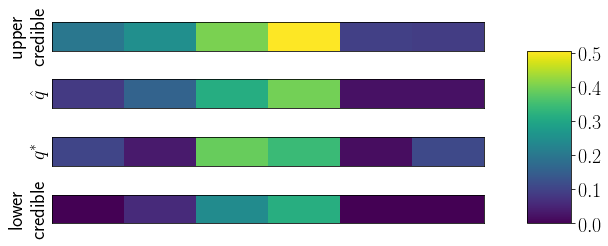

In [13]:
xtilde=0


mx=CIs[[xtilde],:,1].max()

plt.gcf().add_axes([0,.6,1,.1])
plt.ylabel("upper\n credible"); plt.xticks([]); plt.yticks([])
plt.pcolor(CIs[[xtilde],:,1],vmin=0,vmax=mx)

plt.gcf().add_axes([0,.4,1,.1])
plt.ylabel("$\hat q$"); plt.xticks([]); plt.yticks([])
plt.pcolor(qhat[[xtilde]],vmin=0,vmax=mx)

plt.gcf().add_axes([0,.2,1,.1])
plt.ylabel("$q^*$"); plt.xticks([]); plt.yticks([])
plt.pcolor(qxy_star[[xtilde]],vmin=0,vmax=mx)

plt.gcf().add_axes([0,0,1,.1])
plt.ylabel("lower\n credible"); plt.xticks([]); plt.yticks([])
mappable=plt.pcolor(CIs[[xtilde],:,0],vmin=0,vmax=mx)

plt.gcf().add_axes([1.1,0,.1,.6])
plt.colorbar(mappable=mappable,cax=plt.gca())

Looks sensible.  The truth is certainly between the lower and upper.  

### another example: MANY samples but not many sampling kinds

In [30]:
# pick the number of populations and the number of different values that can be returned by each tool
num_ells=2
num_xs=6
num_ys=6

plx_star = np.array([npr.dirichlet(np.ones(num_xs)) for x in range(num_ells)])
qxy_star = np.array([npr.dirichlet(np.ones(num_ys)) for x in range(num_xs)])
hly_star= plx_star @qxy_star

nsamps=100000000
Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])



With fewer subpopulations, even if we add many more samples, the error is higher:

In [31]:
qhat,CIs = markovlink.estimates(Nlx,Nly)
print("err",markovlink.totalvardist(qhat,qxy_star))

err 0.2673785542283032


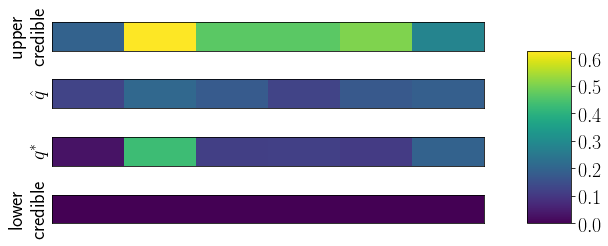

In [32]:
xtilde=0

mx=CIs[[xtilde],:,1].max()

plt.gcf().add_axes([0,.6,1,.1])
plt.ylabel("upper\n credible"); plt.xticks([]); plt.yticks([])
plt.pcolor(CIs[[xtilde],:,1],vmin=0,vmax=mx)

plt.gcf().add_axes([0,.4,1,.1])
plt.ylabel("$\hat q$"); plt.xticks([]); plt.yticks([])
plt.pcolor(qhat[[xtilde]],vmin=0,vmax=mx)

plt.gcf().add_axes([0,.2,1,.1])
plt.ylabel("$q^*$"); plt.xticks([]); plt.yticks([])
plt.pcolor(qxy_star[[xtilde]],vmin=0,vmax=mx)

plt.gcf().add_axes([0,0,1,.1])
plt.ylabel("lower\n credible"); plt.xticks([]); plt.yticks([])
mappable=plt.pcolor(CIs[[xtilde],:,0],vmin=0,vmax=mx)

plt.gcf().add_axes([1.1,0,.1,.6])
plt.colorbar(mappable=mappable,cax=plt.gca())

Notice that in this case the estimate $\hat q$ may be pretty off-base, but the credible intervals still generally contain the truth, $q^*$.

In [34]:
qhat,CIs = markovlink.estimates(Nlx,Nly,subCIs=[((0,0))])

In [35]:
CIs

array([[0.        , 0.19522797]])

### test: how does MLM depend upon with different amounts of data and subpopulations?

change number of subpops and number of samples.  look at error, along with coverage for the credibleinterval of `q[0,0]`.

In [52]:
num_subpops=[2,4,6,10,15,20]
num_samps=np.require(10*np.exp(np.r_[0:11:100j]),dtype=np.int)
# num_samps=np.require(10*np.exp(np.r_[0:11:10j]),dtype=np.int)

num_xs=6
num_ys=6

actual_numsamps=np.zeros((len(num_subpops),len(num_samps)))
error=np.zeros((len(num_subpops),len(num_samps)))
CIinfo=np.ones((len(num_subpops),len(num_samps),3))*np.nan
pointests=np.ones((len(num_subpops),len(num_samps)))*np.nan

In [54]:
# # this is /slow:
# for i,num_subpop in enumerate(num_subpops):   
#     print("\n",i,":",num_subpop)
#     for j,num_samp in enumerate(num_samps):
#         markovlink.pnn(j)
#         plx_star = np.array([npr.dirichlet(np.ones(num_xs)) for x in range(num_subpop)])
#         qxy_star = np.array([npr.dirichlet(np.ones(num_ys)) for x in range(num_xs)])
#         hly_star= plx_star @qxy_star

#         nsamps=5+num_samp//num_subpop
#         Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
#         Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])

#         qhat,CIs = markovlink.estimates(Nlx,Nly,subCIs=[((0,0))],nsamps=10)
        
#         CIinfo[i,j,:2]=CIs[0]
#         CIinfo[i,j,2]=qxy_star[0,0]
#         pointests[i,j]=qhat[0,0]
#         error[i,j]=markovlink.misc.totalvardist(qhat,qxy_star)
#         actual_numsamps[i,j]=nsamps*2*num_subpop
        

# with open('data/simulation_cis.pkl','wb') as f:
#     pickle.dump(dict(actual_numsamps=actual_numsamps,error=error,CIinfo=CIinfo,pointests=pointests),f)

# # here we saved the results
with open('data/simulation_cis.pkl','rb') as f:
    locals().update(pickle.load(f))

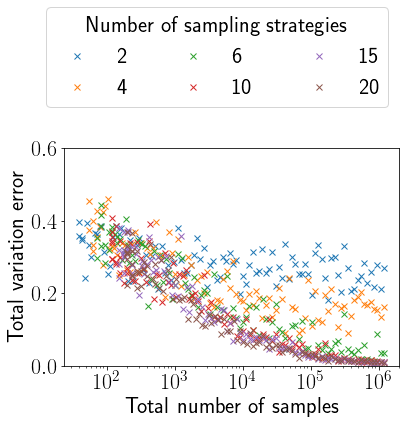

In [55]:
matplotlib.rc('font', size=22)

for i,num_subpop in enumerate(num_subpops):
    plt.semilogx(actual_numsamps[i],error[i],'x',label='%d'%num_subpop,alpha=1.0)

plt.xlabel("Total number of samples")
plt.ylabel("Total variation error")
plt.ylim(0,.6)


plt.legend(ncol=3,bbox_to_anchor=[1.0,1.7],title="Number of sampling strategies")

plt.savefig("images/simulationI.png",dpi=300,bbox_inches='tight')

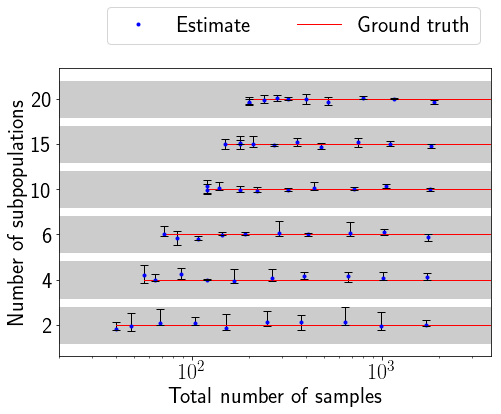

In [60]:


plt.gcf().add_axes([1.3,0,1,1])

sizes=CIinfo[:,:,1]-CIinfo[:,:,0]

SM=2.5

# sampslice=slice(0,len(num_samps),7)
# sampslice=slice(0,len(num_samps))
sampslice=np.require(np.r_[0:40:10j],dtype=np.int)

for GG,num_subpop in enumerate(num_subpops):
   
    
    xs=[0,actual_numsamps.max()*2]
    ys1=[GG*SM-1,GG*SM-1]
    ys2=[GG*SM+1,GG*SM+1]
    plt.fill_between(xs,ys1,ys2,color='#cccccc')
    
    truths=plt.plot([actual_numsamps[GG][0],actual_numsamps[GG][-1]],[GG*SM,GG*SM],'r-',linewidth=1)

    yerrs=np.array([CIinfo[GG,:,2]-CIinfo[GG,:,0],CIinfo[GG,:,1]-CIinfo[GG,:,2]])
    yerrs2=np.array([CIinfo[GG,:,2]-0,1-CIinfo[GG,:,2]])
    
    yerrs3=pointests[GG]-CIinfo[GG,:,2]
    
    ests=plt.plot(actual_numsamps[GG][sampslice],yerrs3[sampslice]+GG*SM,'b.')

    ticks=plt.errorbar(actual_numsamps[GG][sampslice], GG*SM+np.zeros(len(actual_numsamps[GG]))[sampslice], 
                    yerr=yerrs[:,sampslice],capsize=4,linewidth=1,capthick=1,linestyle='',color='black')
#     plt.errorbar(actual_numsamps[GG][::7], GG*2+np.zeros(len(actual_numsamps[GG]))[::7], 
#                     yerr=yerrs2[:,::7],capsize=0,linewidth=1,linestyle=' ',color='blue')
    
    
plt.xlim(actual_numsamps[0][sampslice][0]*.5,actual_numsamps[-1][sampslice][-1]*2)
        
plt.legend([ests[0],truths[0]],['Estimate','Ground truth'],bbox_to_anchor=[1.0,1.25],ncol=2)

plt.gca().set_xscale("log", nonposx='clip')
        
plt.yticks(SM*np.r_[0:len(num_subpops)],num_subpops)

plt.xlabel("Total number of samples")
plt.ylabel("Number of subpopulations")
    
    
plt.savefig("images/simulationIconf.png",dpi=300,bbox_inches='tight')

### test: varying the nature of the link

In [953]:
num_ells=4
num_xs=6
num_ys=num_xs

# we will use the same plx throughout
plx_star = np.array([npr.dirichlet(np.ones(num_xs)*1) for x in range(num_ells)])

# in each sub-experimetn will be a convex combination between AA and BB
AA=np.eye(num_xs)
BB=np.zeros((num_xs,num_xs)); BB[:]=npr.dirichlet(np.ones(num_xs)).reshape((1,-1))

In [954]:
# convexs index the progression from independent to deterministic
convexs=np.r_[0:1:500j][1:-1]

# nsamps are the different number of samples we use
nsamps=[5,50,500,5000]

In [44]:

# this is slow
# # we keep track of the error for each q and each number of samples
# errs=np.zeros((len(convexs),len(nsamps)))

# # iterate through the possible values of q
# for i,conv in enumerate(convexs):
#     markovlink.misc.pnn(i)
    
#     # make the q parameters as a function of conv
#     qxy_star = AA*conv+(1-conv)*BB
#     hly_star= plx_star @qxy_star
    
#     # for each number of samples, simulate a dataset of that size, 
#     # estimate q from the dataset, and report the error
#     for j,nsamp in enumerate(nsamps):
#         Nlx=np.array([npr.multinomial(nsamp,x) for x in plx_star])
#         Nly=np.array([npr.multinomial(nsamp,x) for x in hly_star])
#         ptilde,qtilde= markovlink.point_estimates(Nlx,Nly,maxtime=120)
#         errs[i,j]=markovlink.misc.totalvardist(qtilde,qxy_star)
    
# with open('data/simulation_varylink.pkl','wb') as f:
#     pickle.dump(dict(errs=errs,nsamps=nsamps,convexs=convexs,AA=AA,BB=BB,plx_star=plx_star),f)
                
# # here we saved the results
with open('data/simulation_varylink.pkl','rb') as f:
    locals().update(pickle.load(f))
    

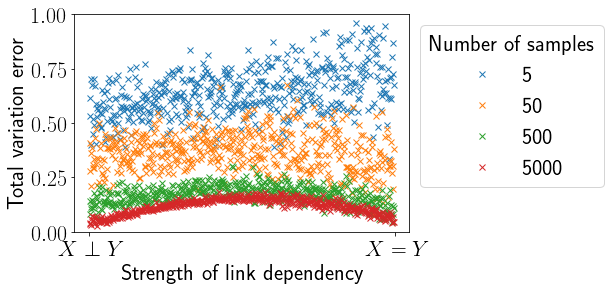

In [45]:
matplotlib.rc('font', size=22)

for j,nsamp in enumerate(nsamps):
    plt.plot(convexs,errs[:,j],'x',label='%d'%nsamp,alpha=1.0)
plt.ylim(0,1.0)
plt.ylabel("Total variation error")
plt.xticks([0,1],['$X\\perp Y$','$X=Y$'])
plt.xlabel("Strength of link dependency")
plt.legend(ncol=1,bbox_to_anchor=[1.0,1.0],title='Number of samples')
plt.savefig('images/simulationII.png',dpi=300,bbox_inches='tight')

# allen institute results

In [2]:
# example input: two matrices, Nly and Nlx
with open('data/tables.pkl','rb') as f:
    locals().update(pickle.load(f))

Our original data comes in the form of two tables.

The first table, `Nlx`, gives the result of running technique I one some data.  This technique takes in a given specimen and returns one of a finite number of different responses, each of which tells us something different about the specimen.  In this case, these responses corresponded to guesses about the cell type of the specimens, which were cells.  In general, any measurement tool that gives one of a discrete number of responses can be used (or, if the response is continuous, we can bin responses to make them discrete).  

To be concrete: `Nlx[l,x]` gives the  the number of samples from subpopulation `l` that that measured as `x` by technique I.  We expect `Nlx` to be a numpy matrix.  

Our input data also has 
- `cre_names`, which gives the name of each subpopulation
- `facs_names`, which gives the name of each possible `x` measurement
- `patch_names`, which gives the name of each possible `y` measurement

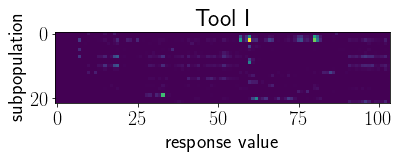

In [22]:
plt.imshow(Nlx); plt.ylabel('subpopulation'); plt.xlabel("response value");
plt.title("Tool I");

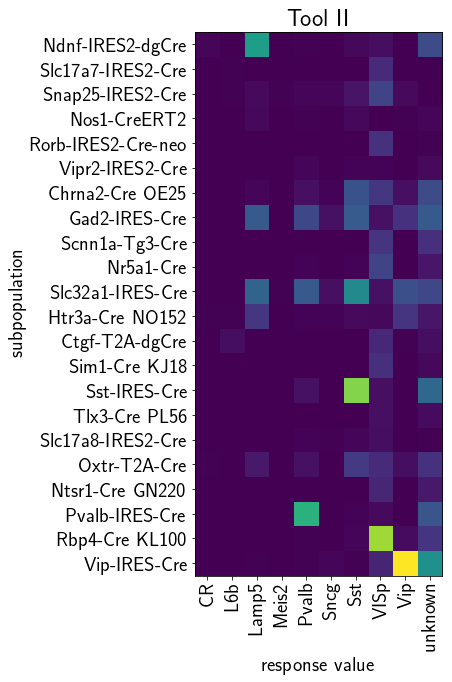

In [23]:
plt.imshow(Nly); 
plt.ylabel('subpopulation'); plt.xlabel("response value"); 
plt.title("Tool II")
plt.gcf().set_size_inches(10,10)
plt.yticks(range(len(cre_names)),[s.replace('_',' ') for s in cre_names])
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical');

In no case was the *same specimen* observed using both techniques.  However, both techniques sampled from the same set of subpopulations.  Using a Markov Link assumption, this enables us to determine a set of possible calibrations, or correspondences between the two methods.

Here we draw a picture showing a close up of some of these tables:

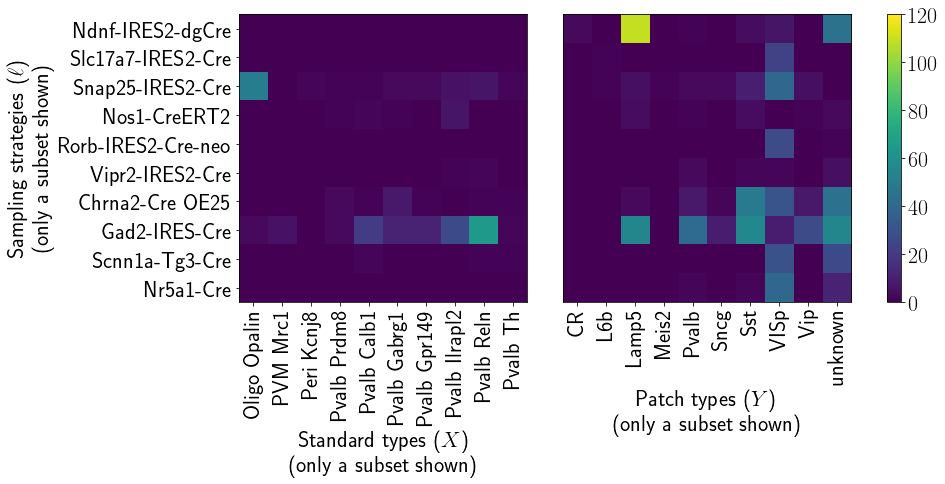

In [48]:
NSUB=np.r_[25:35]
CRESUB=np.r_[:10]
prop=.04
plt.gcf().add_axes([0,0,len(NSUB)*prop,len(CRESUB)*prop])
plt.imshow(Nlx[CRESUB][:,NSUB],vmin=0,vmax=120); 
plt.ylabel('Sampling strategies ($\ell$) \n (only a subset shown)'); plt.xlabel("Response value");
plt.xlabel("Standard types ($X$) \n (only a subset shown)")
plt.gcf().set_size_inches(25,10)
plt.yticks(range(len(CRESUB)),[s.replace('_',' ') for s in cre_names[CRESUB]])
plt.xticks(range(len(NSUB)),[s.replace('_',' ') for s in facs_names[NSUB]],rotation='vertical')

plt.gcf().add_axes([len(NSUB)*prop+.05,0,Nly.shape[1]*prop,len(CRESUB)*prop])
foo=plt.imshow(Nly[CRESUB],vmin=0,vmax=120); 
plt.gcf().set_size_inches(10,10)
plt.yticks([])
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical');
plt.xlabel("Patch types ($Y$) \n (only a subset shown)")

plt.gcf().add_axes([len(NSUB)*prop+.05+Nly.shape[1]*prop+.05,0,.02,len(CRESUB)*prop])
plt.colorbar(mappable=foo,cax=plt.gca())

plt.savefig("images/allenNlxy.png",dpi=300,bbox_inches='tight')

### foo

In [3]:
# get estimates
estimates=markovlink.approxbayes.posterior_samples(Nlx,Nly,nsamps=40,verbose=True)


 40 samples to produce: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [4]:
# try to get just one
# print(markovlink.approxbayes.credible_interval(estimates,4,0,verbose=True))
print(markovlink.approxbayes.credible_interval(estimates[:20],3,7,verbose=True))
# print(markovlink.approxbayes.credible_interval(estimates,0,4,verbose=True))

0 cond=0.012015 coneopt suc cond=0.012015 coneopt suc 1 cond=0.010170 coneopt nonopt suc cond=0.010170 coneopt suc 2 cond=0.008772 coneopt suc cond=0.008772 coneopt suc 3 cond=0.010543 coneopt suc cond=0.010543 coneopt suc 4 cond=0.010145 coneopt suc cond=0.010145 coneopt suc 5 cond=0.011087 coneopt suc cond=0.011087 coneopt suc 6 cond=0.012691 coneopt suc cond=0.012691 coneopt suc 7 cond=0.010338 coneopt nonopt suc cond=0.010338 coneopt suc 8 cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc 9 cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 10 cond=0.009982 coneopt suc cond=0.009982 coneopt suc 11 cond=0.009832 coneopt suc cond=0.009832 coneopt suc 12 cond=0.010744 coneopt suc cond=0.010744 coneopt suc 13 cond=0.009798 coneopt suc cond=0.009798 coneopt nonopt suc 14 cond=0.009215 coneopt suc cond=0.009215 coneopt suc 15 cond=0.010150 coneopt suc cond=0.010150 coneopt suc 16 cond=0.010741 coneopt suc cond=0.010741 coneopt nonopt suc 17 cond=0.010455 coneopt suc cond

In [7]:
szL,szX=Nlx.shape
szL,szY=Nly.shape
Y,X=np.meshgrid(np.r_[0:szY],np.r_[0:szX])
xys=np.c_[X.ravel(),Y.ravel()]
xys[37]

array([3, 7])

In [6]:
%debug

> /home/jovyan/work/papers/2018_02_21_trygve/markov-link-method/markovlink/polytopes.py(284)cvxopt_linprog()
    282     # Let's check the primal and dual infeasibilities
    283 
--> 284     raise Exception("foo")
    285 
    286 

ipdb> print(rez)
{'x': <1040x1 matrix, tc='d'>, 'y': <302x1 matrix, tc='d'>, 's': <1040x1 matrix, tc='d'>, 'z': <1040x1 matrix, tc='d'>, 'status': 'unknown', 'gap': 9.241083455384566e-07, 'relative gap': 0.0010382571411273033, 'primal objective': -0.0008900572978819988, 'dual objective': -0.0008901150797114869, 'primal infeasibility': 2.3601496398713263e-09, 'dual infeasibility': 2.857447428075277e-07, 'primal slack': 3.41000315124002e-11, 'dual slack': 8.934541185812559e-10, 'residual as primal infeasibility certificate': None, 'residual as dual infeasibility certificate': 1123.5231738601772, 'iterations': 21}
ipdb> rez['gap'[
*** SyntaxError: unexpected EOF while parsing
ipdb> rez['gap']
9.241083455384566e-07
ipdb> quit


In [5]:
szL,szX=Nlx.shape
szL,szY=Nly.shape

Y,X=np.meshgrid(np.r_[0:szY],np.r_[0:szX])
xys=np.c_[X.ravel(),Y.ravel()]
CIs=markovlink.approxbayes.credible_intervals(estimates[:10],xys,alpha=.05,verbose=True,onfail='warn')
CIs=CIs.reshape((szX,szY,2))

 1040 parameters look at: 0 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 1 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc c

cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt nonopt suc 16 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 17 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.01

coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 31 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 32 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 cone

coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 46 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 47 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 cone

coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 61 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 62 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.0126

suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 77 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt su

coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 92 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 93 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.0105

suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 107 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 108 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc 

coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 123 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneop

coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 138 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 139 cond=0.012015 coneopt suc co

suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 153 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 154 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneo

nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 168 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 169 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt su

cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 184 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc c

cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 199 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 200 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 co

coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 214 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 215 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt

suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 229 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 230 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt su

coneopt suc 244 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 245 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt

coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 260 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0

cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 275 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 276 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 co

suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 290 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 291 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt su

coneopt suc cond=0.009937 coneopt nonopt suc 305 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 306 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.0115

coneopt nonopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 321 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 322 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.0101

coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 336 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 337 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 cone

cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 352 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 353 cond=0.012015 coneopt

cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 367 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 368 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt s

suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 382 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 383 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc 

coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 398 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond

suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 413 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 414 cond=0.012015 coneopt suc cond=0.012015 coneopt suc 

suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 428 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 429 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.011087 coneo

suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 444 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.00

coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 459 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 460 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond

suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 474 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 475 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.01014

coneopt suc cond=0.009937 coneopt suc 489 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 490 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 co

cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 505 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 506 cond=0.012015 

coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt suc 520 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 521 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond

suc cond=0.009937 coneopt nonopt suc 535 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 536 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt no

coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 551 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 552 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond

suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 566 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 567 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt 

suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 581 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 582 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.01269

suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 597 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc co

suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 612 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 613 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc 

cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 628 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt suc 629 cond=0.012015 coneopt suc cond=0.012015 co

suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 643 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 644 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.01014

cond=0.009937 coneopt suc cond=0.009937 coneopt suc 658 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 659 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt n

coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 674 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 675 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.0087

coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 689 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt suc 690 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.01

nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 705 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 co

suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 720 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 721 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.00877

coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 735 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 736 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.0103

coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 751 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 752 cond=0.012015 coneopt suc cond=0.012015 cone

coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 766 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 767 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt s

suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 782 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt s

cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 797 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 798 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt

coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 812 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 813 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.0126

suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 828 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 829 cond=0.012015 coneopt suc cond=

suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 843 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 844 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=

suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 858 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 859 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc 

coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 874 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 875 cond=0.012015 cone

coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 889 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 890 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt

cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 904 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 905 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt

coneopt suc cond=0.009937 coneopt suc 919 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt suc 920 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt nonopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt s

cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt nonopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 935 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt nonopt suc cond=0.009937 coneopt suc 936 cond=0.012015 coneopt suc cond=0.012015 coneopt

coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 950 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 951 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.0101

coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 966 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 c

coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 981 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 982 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.0101

coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 996 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt nonopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 997 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt nonopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt nonopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 co

cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 1012 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt nonopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 1013 cond=0.012015 coneopt nonopt suc cond=0.012015 coneopt suc cond=0.

coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt suc 1027 cond=0.012015 coneopt suc cond=0.012015 coneopt nonopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt nonopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt suc cond=0.011087 coneopt suc cond=0.012691 coneopt suc cond=0.012691 coneopt suc cond=0.010338 coneopt suc cond=0.010338 coneopt suc cond=0.011568 coneopt suc cond=0.011568 coneopt suc cond=0.009937 coneopt suc cond=0.009937 coneopt nonopt suc 1028 cond=0.012015 coneopt suc cond=0.012015 coneopt suc cond=0.010170 coneopt suc cond=0.010170 coneopt suc cond=0.008772 coneopt suc cond=0.008772 coneopt suc cond=0.010543 coneopt suc cond=0.010543 coneopt suc cond=0.010145 coneopt suc cond=0.010145 coneopt suc cond=0.011087 coneopt

In [8]:
# with open('data/allen_results.pkl','wb') as f:
#     pickle.dump(dict(qhat=qhat,CIs=CIs),f)

In [7]:
qhat=np.mean([q for (p,q) in estimates],axis=0)

In [4]:
qhat=np.mean([q for (p,q) in estimates],axis=0)

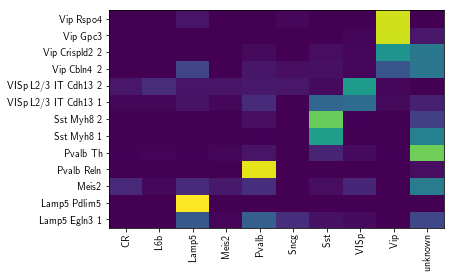

In [5]:

NSUB=[13,18,21,33,34,51,52,58,59,93,95,96,102]
plt.pcolor(qhat[NSUB])
plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical');
plt.yticks(np.r_[0:len(NSUB)]+.5,[x.replace('_'," ") for x in facs_names[NSUB]]);

In [37]:
# markovlink.approxbayes.credible_interval([estimates[6]],0,0)
markovlink.approxbayes.credible_interval(estimates,0,0)

(8.533629920947495e-17, 0.9999999981066816)

In [35]:
%debug

> /home/jovyan/work/papers/2018_02_21_trygve/markov-link-method/markovlink/polytopes.py(278)cvxopt_linprog()
    276         raise LinearProgrammingFailure("Linear programming failed! (%s)"%(rez['status']))
    277 
--> 278 
    279     return np.array(rez['x'])
    280 

ipdb> up
> /home/jovyan/work/papers/2018_02_21_trygve/markov-link-method/markovlink/polytopes.py(189)find_extremal()
    187     # find relevant extremal point with interior point method
    188     if use_cvxopt:
--> 189         return cvxopt_linprog(c,A_eq,b_eq,qxy.ravel()).reshape(qxy.shape)
    190     else:
    191         return scipy_linprog(c,A_eq,b_eq).reshape(qxy.shape)

ipdb> up
> /home/jovyan/work/papers/2018_02_21_trygve/markov-link-method/markovlink/approxbayes.py(51)get_extremes()
     49         direc[xtilde,ytilde]=1
     50 
---> 51         lower[i]=polytopes.find_extremal(ptilde,qtilde,direc)
     52         upper[i]=polytopes.find_extremal(ptilde,qtilde,-direc)
     53 

ipdb> print(i)
22
ipdb> qui

In [ ]:
szL,szX=Nlx.shape
szL,szY=Nly.shape

Y,X=np.meshgrid(np.r_[0:szY],np.r_[0:szX])
xys=np.c_[X.ravel(),Y.ravel()]
CIs=markovlink.approxbayes.credible_intervals(estimates,xys,alpha=.05,verbose=True,onfail='warn')
CIs=CIs.reshape((szX,szY,2))


 1040 parameters look at: 0 1 

In [36]:
# WTF?

p,q=estimates[22]
direc=np.zeros(q.shape)
direc[0,0]=1

markovlink.polytopes.find_extremal(p,q,-direc,use_cvxopt=True)

{'x': <1040x1 matrix, tc='d'>, 'y': <302x1 matrix, tc='d'>, 's': <1040x1 matrix, tc='d'>, 'z': <1040x1 matrix, tc='d'>, 'status': 'unknown', 'gap': 7.910179684712095e-07, 'relative gap': 4.3968010452455255e-06, 'primal objective': -0.17990761017639761, 'dual objective': -0.17990760483711182, 'primal infeasibility': 1.3438677581909568e-09, 'dual infeasibility': 2.4128450435849206e-07, 'primal slack': 1.955136112567466e-11, 'dual slack': 7.60615259971555e-10, 'residual as primal infeasibility certificate': None, 'residual as dual infeasibility certificate': 5.558408558895302, 'iterations': 21}


LinearProgrammingFailure: Linear programming failed! (unknown)

In [32]:
# WTF?

p,q=estimates[4]
direc=np.zeros(q.shape)
direc[0,0]=1

markovlink.polytopes.find_extremal(p,q,-direc,use_cvxopt=True)

array([[1.69347431e-04, 3.50433398e-07, 1.13942892e-07, ...,
        5.98820591e-07, 5.10244166e-07, 9.99828456e-01],
       [3.49138648e-11, 6.10697943e-07, 2.11715599e-07, ...,
        1.07863427e-06, 4.76516395e-07, 9.99996732e-01],
       [1.00000000e+00, 2.27627749e-10, 2.27498161e-10, ...,
        2.27349793e-10, 2.27168625e-10, 2.27011578e-10],
       ...,
       [2.01905499e-05, 1.71040556e-06, 1.66763340e-07, ...,
        7.33360020e-07, 9.01391939e-06, 9.99958293e-01],
       [1.04563441e-11, 3.77009323e-07, 1.73368453e-05, ...,
        2.53331047e-07, 9.99981192e-01, 1.94011057e-07],
       [2.28575086e-11, 1.94745148e-06, 5.58770933e-01, ...,
        2.86437967e-06, 4.22114946e-01, 1.21268315e-06]])

In [17]:
A_eq,b_eq = markovlink.polytopes.q_with_fixedph(p,p@q,precondition=False)

In [20]:
len(np.linalg.svd(A_eq)[1]),A_eq.shape[0]

(302, 302)

In [22]:
np.linalg.svd(A_eq)[1].min()

0.011204366819156084

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

{'status': 'primal infeasible', 'x': None, 's': None, 'y': None, 'z': None, 'primal objective': None, 'dual objective': None, 'gap': None, 'relative gap': None, 'primal infeasibility': None, 'dual infeasibility': None, 'primal slack': None, 'dual slack': None, 'residual as primal infeasibility certificate': None, 'residual as dual infeasibility certificate': None}


LinearProgrammingFailure: Linear programming failed! (primal infeasible)

In [102]:
lower[0,0],upper[0,0]

(1.53908357110239e-09, 1.449323239523165e-07)

NameError: name 'direc' is not defined

In [23]:

upper=markovlink.polytopes.find_extremal(p,q,-direc,use_cvxopt=False)
lower=markovlink.polytopes.find_extremal(p,q,direc,use_cvxopt=False)

KeyboardInterrupt: 

In [ ]:
lower,upper

In [104]:
%debug

> /home/jovyan/work/papers/2018_02_21_trygve/markov-link-method/markovlink/polytopes.py(262)cvxopt_linprog()
    260     else:
    261         print(rez)
--> 262         raise LinearProgrammingFailure("Linear programming failed! (%s)"%(rez['status']))
    263 
    264 

ipdb> print(initialcondition.min())
0.0
ipdb> print(A_eq @ initialcondition-b_eq)
[-2.08166817e-17  3.46944695e-18 -5.55111512e-17  5.20417043e-18
  6.93889390e-18 -3.46944695e-18  0.00000000e+00 -1.38777878e-17
  3.46944695e-18  3.46944695e-18  2.77555756e-17 -6.93889390e-18
  1.73472348e-18  0.00000000e+00  0.00000000e+00  2.77555756e-17
 -1.11022302e-16  3.46944695e-18  6.93889390e-18  6.93889390e-18
  2.08166817e-17  0.00000000e+00  0.00000000e+00  6.93889390e-18
 -1.38777878e-17  1.11022302e-16  0.00000000e+00 -1.38777878e-17
 -3.46944695e-18  0.00000000e+00 -6.93889390e-18  0.00000000e+00
  3.46944695e-18  1.94289029e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.08166817e-17 -3.46944695e-

### run the MLM

In [12]:
# this is slow:
qhat,CIs=markovlink.estimates(Nlx,Nly,onfail='warn',verbose=True,nsamps=100)
with open('data/allen_results2.pkl','wb') as f:
    pickle.dump(dict(qhat=qhat,CIs=CIs),f)

# # here we saved the reult:
# with open('data/allen_cis2.pkl','rb') as f:
#     CIs=pickle.load(f)


 100 samples to produce: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
 1040 parameters look at: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 (fail Couldn't solve the LP) 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 (fail Couldn't solve the LP) 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 (fail Couldn't solve the LP) 83 84 85 86 87 88 89 (fail Couldn't solve the LP) 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162

In [20]:
# here we saved the reult:
with open('data/allen_cis2.pkl','rb') as f:
    CIs2=pickle.load(f)
    good=np.isnan(CIs2).any(axis=2)
    CIs2[~good][:,0]=0
    CIs2[~good][:,1]=1

### Look at the results

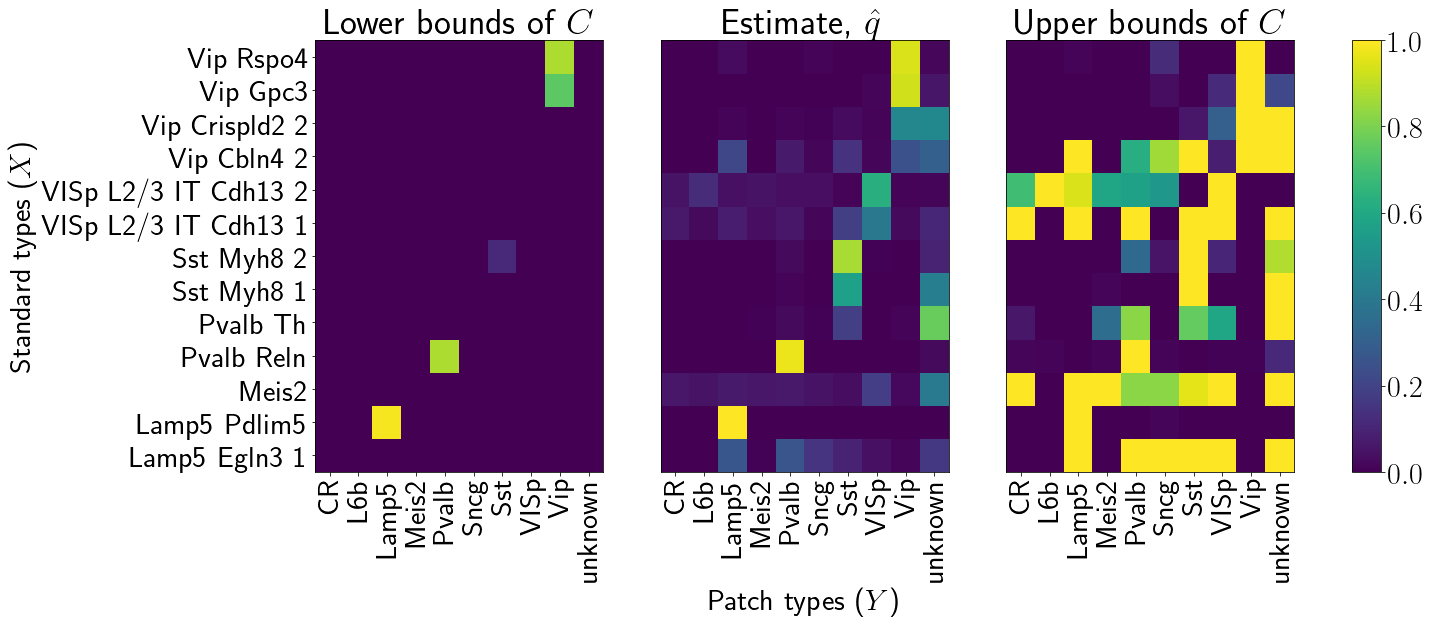

In [21]:
matplotlib.rc('font', size=30)
plt.gcf().set_size_inches(4,6)

# select a subset of Standard types
NSUB=[13,18,21,33,34,51,52,58,59,93,95,96,102]

plt.gcf().add_axes([0,0,1,1])
plt.pcolor(CIs2[NSUB,:,0],vmin=0,vmax=1)
plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical');
plt.yticks(np.r_[0:len(NSUB)]+.5,[x.replace('_'," ") for x in facs_names[NSUB]]);
# plt.xlabel("Patch types ($Y$)")
plt.ylabel("Standard types ($X$)")
plt.title("Lower bounds of $C$")

plt.gcf().add_axes([1.2,0,1,1])
plt.pcolor(qhat[NSUB,:],vmin=0,vmax=1)
plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical'); plt.yticks([])
plt.xlabel("Patch types ($Y$)")
plt.title("Estimate, $\\hat q$")

plt.gcf().add_axes([2.4,0,1,1])
mappable=plt.pcolor(CIs2[NSUB,:,1],vmin=0,vmax=1)
plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical'); plt.yticks([])
# plt.xlabel("Patch types ($Y$)");
plt.title("Upper bounds of $C$")

plt.gcf().add_axes([3.6,0,.1,1])
plt.colorbar(mappable=mappable,cax=plt.gca())

plt.savefig("images/allenout.png",dpi=300,bbox_inches='tight')

In [22]:
CIs2[102]

array([[0.00000000e+00, 1.35022926e-07],
       [0.00000000e+00, 9.50774399e-07],
       [0.00000000e+00, 8.81041336e-03],
       [0.00000000e+00, 3.21853291e-08],
       [0.00000000e+00, 4.76572806e-08],
       [0.00000000e+00, 1.21537128e-01],
       [0.00000000e+00, 1.68688351e-08],
       [0.00000000e+00, 4.38535579e-08],
       [8.76551657e-01, 1.00000000e+00],
       [0.00000000e+00, 1.16305751e-07]])

# a few identifiability case study issues

### a simple failure case

In [49]:
p=np.r_[.5,.5,0,2/6,1/6,3/6].reshape((2,3))
p

array([[0.5       , 0.5       , 0.        ],
       [0.33333333, 0.16666667, 0.5       ]])

In [51]:
q=np.r_[0,1,1,0,1,0].reshape((3,2))
q

array([[0, 1],
       [1, 0],
       [1, 0]])

In [52]:
p@q

array([[0.5       , 0.5       ],
       [0.66666667, 0.33333333]])

In [59]:
direc=np.zeros(q.shape); direc[0,0]=1
q2=markovlink.polytopes.find_extremal(p,q,-direc)
q2

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.66666667, 0.33333333]])

In [58]:
p@q2

array([[0.5       , 0.5       ],
       [0.66666667, 0.33333333]])